<a href="https://colab.research.google.com/github/v1an1/gradcamplusplus-cats-v-dogs/blob/master/dogs_vs_cats_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Replace it with the path of cats-v-dogs and test zipfiles

!unzip '/content/drive/My Drive/cats-v-dogs.zip'
!unzip '/content/drive/My Drive/catvsdog/test.zip'

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [0]:
pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [0]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau
import datetime
import numpy as np
import pandas as pd
import os

In [0]:
TRAINING_DIR = "/content/cats-v-dogs/train/"
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,  
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

VALIDATION_DIR = "/content/cats-v-dogs/validation/"
validation_datagen = ImageDataGenerator(rescale=1./255)

# VALIDATION GENERATOR.
validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [0]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [0]:
os.mkdir('/')

In [0]:
log_dir = "/content/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = "/content/checkpoint/"
#Prepare call backs
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
LR_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=2, factor=.5, min_lr=.00001)
EarlyStop_callback = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

my_callback=[EarlyStop_callback, LR_callback, tensorboard_callback, cp_callback]

In [0]:
pre_trained_model = InceptionV3(input_shape=(150,150,3),include_top=False,weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

In [0]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [0]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1,activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

In [0]:
# # Another alternative to try out (gives better result)

# layer_to_Freeze=276    
# for layer in model.layers[:layer_to_Freeze]:
#     layer.trainable =False
# for layer in model.layers[layer_to_Freeze:]:
#     layer.trainable=True

# sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
# model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
history = model.fit(train_generator,
                    epochs=30,
                    steps_per_epoch=225,
                    validation_data=validation_generator,
                    validation_steps=250,
                    verbose=2,
                    callbacks=my_callback)

Epoch 1/30

Epoch 00001: saving model to /content/checkpoint/
225/225 - 168s - loss: 0.3164 - accuracy: 0.8886 - val_loss: 0.1245 - val_accuracy: 0.9436 - lr: 1.0000e-04
Epoch 2/30


In [0]:
model.save('my_model.h5')

In [0]:
%tensorboard --logdir logs/fit

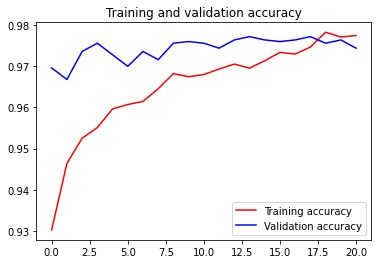

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [0]:
os.mkdir('/content/preds')

In [0]:
mv '/content/test' '/content/preds'

In [0]:
TEST_DIR = "/content/preds"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=20,
    class_mode=None,
    shuffle=False
)

Found 12500 images belonging to 1 classes.


In [0]:
# Run only if previous instance of it is called otherwise neglect
# test_generator.reset()

In [0]:
pred=model.predict(test_generator,verbose=1)

391/391 [==============================] - 38s 97ms/step


In [0]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [0]:
cl=np.round(pred)
cl=np.squeeze(cl, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in cl]

In [0]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [0]:
# For generating csv in terms of prediction
counter = range(1, len(filenames) + 1)
solution = pd.DataFrame({"id": counter, "label":list(pred)})
cols = ['label']

for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

solution.to_csv("dogsVScats.csv", index = False)

In [0]:
# GradCam & GradCam++

from scipy.ndimage.interpolation import zoom
import numpy as np

from keras.backend import tensorflow_backend
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt

def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def add_eps(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10)

def grad_cam(input_model, image, layer_name,H=150,W=150):
    cls = np.argmax(input_model.predict(image))
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = add_eps(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    #print (cam)

    cam = np.maximum(cam, 0)
    #cam = resize(cam, (H, W))
    cam = zoom(cam,H/cam.shape[0])
    #cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def grad_cam_plus(input_model, img, layer_name,H=150,W=150):
    cls = np.argmax(input_model.predict(img))
    y_c = input_model.output[0, cls]
    #cost = 全部のラベルの値。cost*label_indexでy_cになる
    conv_output = input_model.get_layer(layer_name).output
    #conv_output = target_conv_layer, mixed10の出力1,5,5,2048
    grads = K.gradients(y_c, conv_output)[0]
    grads = add_eps(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads
    
    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    #print deep_linearization_weights
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = zoom(cam,H/cam.shape[0])
    cam = cam / np.max(cam) # scale 0 to 1.0    
    # cam = resize(cam, (150,150))

    return cam

In [0]:
# new_model = tf.keras.models.load_model('my_model.h5')

IMG :  test/55.jpg
class activation map for: cats
Probability :  0.9999814


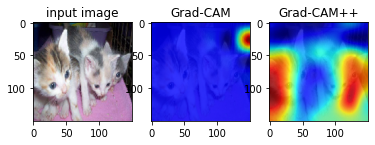

In [0]:
path = "/content/preds/"
img = "test/55.jpg"
image_path = os.path.join(path, img)
orig_image = load_img(image_path, target_size=(150, 150))
image = img_to_array(orig_image)
image = np.expand_dims(image, axis=0)
image = image/255.0

gradcam=grad_cam(model,image,layer_name='mixed7')
gradcamplus=grad_cam_plus(model,image,layer_name='mixed7')

print("IMG : ", img)
prob = model.predict(image)
pred_label = np.round(prob[0][0]).astype(int)
if pred_label == 0:
  prob[0][0] = 1-prob[0][0]

labels = {'cats': 0, 'dogs': 1}
labels = dict((v,k) for k,v in labels.items())
print("class activation map for:",labels[pred_label])
print("Probability : ", prob[0][0])

fig, ax = plt.subplots(nrows=1,ncols=3)
plt.subplot(131)
plt.imshow(orig_image)
plt.title("input image")
plt.subplot(132)
plt.imshow(orig_image)
plt.imshow(gradcam,alpha=0.8,cmap="jet")
plt.title("Grad-CAM")
plt.subplot(133)
plt.imshow(orig_image)
plt.imshow(gradcamplus,alpha=0.8,cmap="jet")
plt.title("Grad-CAM++")
plt.show()